In [1]:
import os
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
import trompy as tp
import pandas as pd
from scipy import stats

In [2]:
def get_number_cells (s2p_folder):
    iscell = np.load(os.path.join(s2p_folder, 'iscell.npy'))
    return sum(iscell[:,0])
    

In [3]:
def get_frames(events_file,s2p_length):
    df = pd.read_csv(events_file)

    pump_frames = list(df[df['Item1'] == 'pump_on']['Item2.Item2'])

    pump_frames=[frame for frame in pump_frames if frame < s2p_length-100] #removes event if too close to the end

    licks_frames = list (df[df['Item1']== 'Lick']['Item2.Item2'])
    
    licks_frames=[frame for frame in licks_frames if frame < s2p_length-100] #removes event if too close to the end
    
    return pump_frames, licks_frames

In [4]:
def filter_cell(x):

    t = np.arange(0,len(x)/10,0.1)
    filt = signal.butter(4, 1, 'low', fs=10, output='sos')
    filtered = signal.sosfilt(filt, x)
    
    return filtered
    

In [64]:
def get_activated_cells (s2p_folder,events_file):
    raw_F = np.load(os.path.join(s2p_folder, 'F.npy'))
    neu_F = np.load(os.path.join(s2p_folder, 'Fneu.npy'))
    iscell = np.load(os.path.join(s2p_folder, 'iscell.npy'))
#     stats=np.load(os.path.join(s2p_folder, 'stat.npy'), allow_pickle=True)
    
    s2p_length=len(raw_F[0,:])
    print(s2p_length)
    
    pump_frames, licks_frames= get_frames(events_file,s2p_length)
    
    cell_idx = [idx for idx,vals in enumerate(iscell) if vals[0]==1]
    
    activated_cells=0
    pump_activated_cells=[]
    lick_activated_cells=[]
    
    mean_lick_snips=[]
    mean_pump_snips=[]

    for i, cell in enumerate(cell_idx):
        x = raw_F[cell, :] - 0.7*(neu_F[cell, :])
#         x = raw_F[cell, :]
        x = (x - np.mean(x))/np.std(x)
        x = filter_cell(x)
        
        
        pump_snips = []
        pre=[]
        post=[]
        
        for p in pump_frames:
            pump_snips.append(x[p-50:p+100])
            pre.append(np.mean(x[p-50:p]))
            post.append(np.mean(x[p:p+50]))
        result_pump= stats.ttest_rel(pre, post)
        temp_pump_snips=np.mean(pump_snips, axis=0)
        
        p=result_pump[1]
        if p < 0.05: 
            pump_activated_cells.append(cell)
            mean_pump_snips.append(temp_pump_snips)
            
        
        
        #trials 
        hit=[]
        miss=[]
        licks=[]

        for p in pump_frames: 
            temp=[]
            for l in licks_frames: 
                if l > p and l < p + 100: 
                    temp.append(l)
                    
            if len(temp) > 0: 
                hit.append(p)
            if len(temp) == 0: 
                miss.append(p)
                
            licks.append(temp)
            
            
            
            
        #Snips and p-value hit trials        
                
        hit_snips=[]
        pre_hit=[]
        post_hit=[]
        
        for p in hit: 
            hit_snips.append(x[p-50:p+100])
            pre_hit.append(np.mean(x[p-50:p]))
            post_hit.append(np.mean(x[p:p+50]))
        hit_result= stats.ttest_rel(pre_hit, post_hit)
        
        #Snips and p-value missed trials
        
        miss_snips=[]
        pre_miss=[]
        post_miss=[]
        
        for p in miss: 
            miss_snips.append(x[p-50:p+100])
            pre_miss.append(np.mean(x[p-50:p]))
            post_miss.append(np.mean(x[p:p+50]))
        miss_result= stats.ttest_rel(pre_miss, post_miss)
      
    
        # snips and p-value of first lick in trial 
        temp_lick=[]
        for trial in licks:
            if len(trial) > 0: 
                temp_lick.append(trial[:1])
        first_lick=[trial for sublist in temp_lick for trial in sublist] 
        
        lick_snips=[]
        pre_lick=[]
        post_lick=[]
        
        for p in first_lick:
            lick_snips.append(x[p-50:p+100])
            pre_lick.append(np.mean(x[p-50:p]))
            post_lick.append(np.mean(x[p:p+50]))
        lick_result= stats.ttest_rel(pre_lick, post_lick)
        temp_lick_snips=np.mean(lick_snips, axis=0)
        
        p=lick_result[1]
        if p < 0.05: 
            lick_activated_cells.append(cell)
            mean_lick_snips.append(temp_lick_snips)
    
            

#         print('all',result[1])
#         print('hit', hit_result[1])
#         print('lick', lick_result[1])
#         print('miss', miss_result[1])
        
#         print('---')
    print(pump_activated_cells)
    print(lick_activated_cells)
    
    both_activated_cells=list(set(pump_activated_cells)& set(lick_activated_cells))
    
    n_pump_only=len(pump_activated_cells)-len(both_activated_cells)
    n_lick_only=len(lick_activated_cells)-len(both_activated_cells)
    n_both=len(both_activated_cells)
    n_non=len(cell_idx)-n_pump_only-n_lick_only-n_both
    
    sizes=[n_pump_only,n_lick_only,n_both,n_non]
    labels= 'Pump','Lick','Both','Neither'
    print(both_activated_cells)
    
    fig1, ax1 = plt.subplots()
    ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        startangle=90, colors=['darkgreen','red','yellow','grey'])
    
    
    return mean_lick_snips, mean_pump_snips
    
  



In [65]:
animal="VGP302"
day="031"
date="20221110"
s2p_folder = "C:\\Users\\mko102\\UiT Office 365\\O365-Pipette 2 - Dokumenter\\People\\Mette\\GitHub\\2P\\Processed\\VGP_procd_data_22-12-05\\sub-{}\\ses-{}".format(animal, day)
events_file = "C:\\Users\\mko102\\UiT Office 365\\O365-Pipette 2 - Dokumenter\\People\\Mette\\GitHub\\2P\\Processed\\behav\\sub-{0}\\ses-{1}-{2}\\sub-{0}_ses-{1}_events.csv".format(animal, day, date)


In [66]:
get_number_cells(s2p_folder)

80.0

11680
[124, 154]
[3, 7, 34, 36, 56, 60, 71, 85, 88, 89, 90, 93, 98, 111, 119, 138, 141]
[]


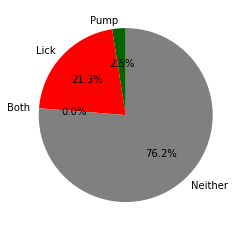

In [67]:
cas_lick,cas_pump=get_activated_cells(s2p_folder,events_file)


In [68]:
animal="VGP302"
day="029"
date="20221108"
s2p_folder = "C:\\Users\\mko102\\UiT Office 365\\O365-Pipette 2 - Dokumenter\\People\\Mette\\GitHub\\2P\\Processed\\VGP_procd_data_22-12-05\\sub-{}\\ses-{}".format(animal, day)
events_file = "C:\\Users\\mko102\\UiT Office 365\\O365-Pipette 2 - Dokumenter\\People\\Mette\\GitHub\\2P\\Processed\\behav\\sub-{0}\\ses-{1}-{2}\\sub-{0}_ses-{1}_events.csv".format(animal, day, date)

11518
[0, 11, 31, 61, 70, 87, 89, 101]
[25, 41, 45, 61, 80]
[61]


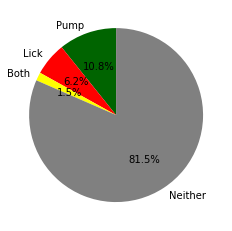

In [69]:
malt_lick,malt_pump=get_activated_cells(s2p_folder,events_file)

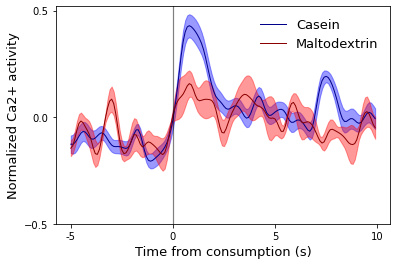

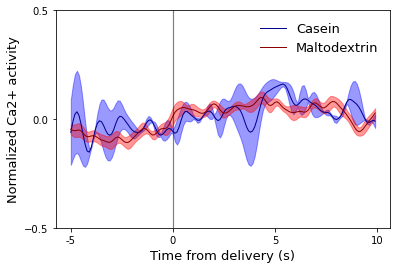

In [70]:
handles='Casein', 'Maltodextrin'


fig2, ax2 = plt.subplots()
tp.shadedError(ax2, cas_lick,linecolor='darkblue',errorcolor='blue')
tp.shadedError(ax2, malt_lick, linecolor='darkred',errorcolor='red')
ax2.set_yticks([-0.5, 0,  0.5])
ax2.set_xticks([0,50,100,150])
ax2.set_xticklabels([-5,0,5,10])
ax2.axvline(50, color='black', alpha=0.5, linewidth=1.2)
ax2.legend(handles, fontsize=13,frameon = False)



fig3, ax3 = plt.subplots()


tp.shadedError(ax3, cas_pump, linecolor='darkblue', errorcolor='blue')
tp.shadedError(ax3, malt_pump, linecolor='darkred', errorcolor='red')
ax3.set_yticks([-0.5, 0,  0.5])
ax3.set_xticks([0,50,100,150])
ax3.set_xticklabels([-5,0,5,10])
ax3.axvline(50, color='black', label='Pump on', alpha=0.5, linewidth=1.2)
ax3.legend(handles, fontsize=13,frameon = False)


ax2.set_ylabel('Normalized Ca2+ activity',fontsize = 13)
ax3.set_ylabel('Normalized Ca2+ activity',fontsize = 13)
ax2.set_xlabel('Time from consumption (s)', fontsize = 13)
ax3.set_xlabel('Time from delivery (s)', fontsize = 13)

fig2.savefig('C:\\Users\\mko102\\GitHub\\VGP\\output\\signal-lick.png')
fig3.savefig('C:\\Users\\mko102\\GitHub\\VGP\\output\\pump-lick.png')

In [ ]:
tp.shadedError?